## Variations in Wind Directions

In this exercise we show the differences in AEP calculation using three approaches - and a deterministic calculation, polynomial chaos (quadrature based), and Monte Carlo sampling - for the directionally averaged wind data from the Princess Amalia Wind Farm in the Netherlands.

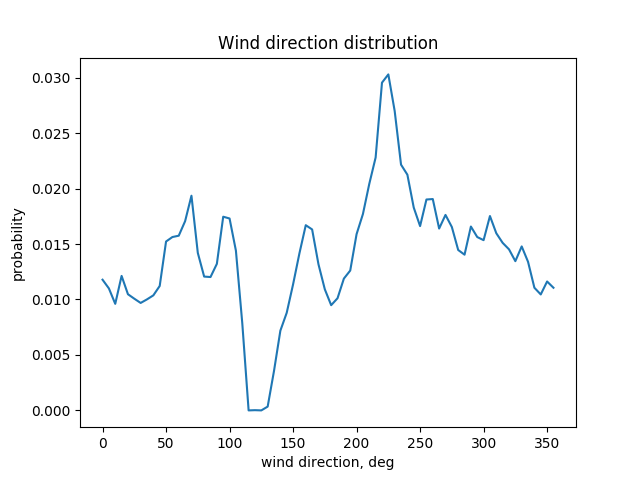

We use a slightly larger grid for a more meaningful study.



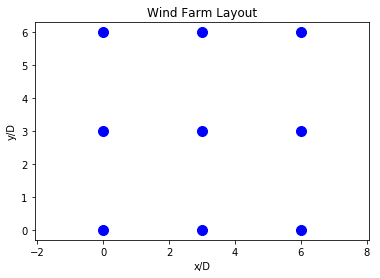

In [43]:
import matplotlib.pyplot as plt

D = 126.4          # rotor diameter

x = np.array([0., 3.*D, 6.*D, 0., 3.*D, 6.*D, 0., 3.*D, 6.*D])            # x and y locations
y = np.array([0., 0., 0., 3.*D, 3.*D, 3.*D, 6.*D, 6.*D, 6.*D])

plt.figure()
plt.plot(x/D, y/D, "bo", markersize=10)
plt.axis('equal')
plt.xlabel("x/D")
plt.ylabel("y/D")
plt.title("Wind Farm Layout")
plt.show()

### Wake overlap

In [63]:
import numpy as np
import scipy as sp
from math import pi


#Determine how much of the turbine is in the wake of the other turbines
def overlap(x, xdown, y, ydown, r, rdown, alpha):
    overlap_fraction = np.zeros(np.size(x))

    for i in range(0, np.size(x)):
        #define dx as the upstream x coordinate - the downstream x coordinate then rotate according to wind direction
        dx = abs(xdown - x[i])
        #define dy as the upstream y coordinate - the downstream y coordinate then rotate according to wind direction
        dy = abs(ydown - y[i])
        # dz = abs(zdown - z[i])
        d = dy  #sp.sqrt(dy**2.+dz**2.)
        R = abs(r[i]+dx*alpha) #The radius of the wake depending how far it is from the turbine
        A = pi*rdown**2  #The area of the turbine
        if dx > 0:
            #if d <= R-rdown:
            #    overlap_fraction[i] = 1 #if the turbine is completely in the wake, overlap is 1, or 100%
            if d == 0:
                #print "Area of turbine: ", A
                #print "Area of wake: ", pi*R**2
                if A <= pi*R**2:

                    overlap_fraction[i] = 1.

                else:

                    overlap_fraction[i] = pi*R**2/A

            elif d >= R+rdown:

                overlap_fraction[i] = 0 #if none of it touches the wake, the overlap is 0
            else:

                #if part is in and part is out of the wake, the overlap fraction is defied by the overlap area/rotor area
                overlap_area = rdown**2.*sp.arccos((d**2.+rdown**2.-R**2.)/(2.0*d*rdown))\
                               +R**2.*sp.arccos((d**2.+R**2.-rdown**2.)/(2.0*d*R))\
                               -0.5*sp.sqrt((-d+rdown+R)*(d+rdown-R)*(d-rdown+R)*(d+rdown+R))

                overlap_fraction[i] = np.real(overlap_area)/A
        else:
            overlap_fraction[i] = 0 #turbines cannot be affected by any wakes that start downstream from them

    return overlap_fraction 


### Velocity decrease

In [64]:
def loss(r_0, a, alpha, x_focus, x, y_focus, y, overlap):
    loss = np.zeros(np.size(x))
    loss_squared = np.zeros(np.size(x))
    dx = np.zeros(len(x))
    dy = np.zeros(len(y))
    for i in range(0, np.size(x)):
        dx = x_focus-x[i]
        dy = abs(y_focus-y[i])
        R = abs(r_0[i]+dx*alpha)
        if dx > 0:
            loss[i] = overlap[i]*2.*a*(r_0[i]/(r_0[i]+alpha*(dx)))**2*0.5*(np.cos(-dy*pi/(R+4*r_0[i])))
            loss_squared[i] = loss[i]**2
        else:
            loss[i] = 0
            loss_squared[i] = 0
    total_loss = sp.sqrt(np.sum(loss_squared))

    return total_loss


### Power calculation

In [65]:
def jensen_power(x, y, r_0, alpha, a, U_velocity, rho, Cp, U_direction):
    "Effective velocity at each turbine"
    x_r, y_r = rotate(x, y, U_direction)
    V = np.zeros([np.size(x)])
    total_loss = np.zeros([np.size(x)])
    P = np.zeros([np.size(x)])
    
    for i in range(0, np.size(x)):
        A = r_0[i]**2*pi
        overlap_fraction = overlap(x_r, x_r[i], y_r, y_r[i], r_0, r_0[i], alpha)
        total_loss[i] = loss(r_0, a, alpha, x_r[i], x_r, y_r[i], y_r, overlap_fraction)
        V = (1-total_loss[i])*U_velocity
        
        P[i] = 0.5*rho*A*Cp*V**3
        
    "Calculate Power from each turbine and the total"

    P_total = np.sum(P)
    return P_total


### Deterministic AEP

In [66]:

xin = np.hstack([x,y])

inputfile = './Simple Wind Farm Applications_files/WindRoses/windrose_amalia_8ms.txt'


nTurbs = len(xin)/2
x_pos = xin[0:nTurbs]
y_pos = xin[nTurbs:nTurbs*2]

theta = 0.1
alpha = sp.tan(theta)
rho = 1.1716
a = 1. / 3.
Cp = 4.*a*(1-a)**2.

r_0 = np.ones(nTurbs)*D/2.
U_inf = 8.
wind_dir_rad = np.array([0., 45., 90., 120.])*np.pi/180.
power_dir = np.zeros(len(wind_dir_rad))

wind_data = np.loadtxt(inputfile)
direction = wind_data[:, 0]*np.pi/180.
speed = wind_data[:, 1]  # Speed is a constant for this file.
likelihood = wind_data[:, 2]

"Calculate power from each turbine"
power_dir = np.zeros(len(direction))
prod  = np.zeros(len(direction))
E_power = 0.


for i in range(len(direction)):
    power_dir[i] = jensen_power(x_pos, y_pos, r_0, alpha, a, U_inf, rho, Cp, direction[i])
    prod[i] = power_dir[i] * likelihood[i]


E_power = np.sum(prod)
AEP_det = 8760*E_power/1e9

print "deterministic:", AEP_det,"GWh"

deterministic: 157.758828754 GWh


### Polynomial Chaos

####  Distribution for chaospy

In [67]:
import chaospy as cp
from scipy.interpolate import interp1d


class amaliaWindRoseRaw01(object):
    """The raw amalia distribution."""

    def __init__(self):
        self.lo = 0.0
        self.hi = 1.0
        self.inputfile = './Simple Wind Farm Applications_files/WindRoses/windrose_amalia_8ms.txt'

    def _wind_rose_func(self):
        wind_data = np.loadtxt(self.inputfile)
        # direction = wind_data[:, 0]
        # speed = wind_data[:, 1]
        probability = wind_data[:, 2]
        N = len(probability)
        probability[probability == 0] = 2e-5  # think about this, # Update where the wind data is zero to the next lowest value
        probability = np.append(probability, probability[0])  # Include the value at 360, which is the same as 0.
        probability = probability*N  # normalize for the [0, 1] range.
        x = np.linspace(0, 1, N+1)
        f = interp1d(x, probability)
        return f

    def pdf(self, x):
        x = x.flatten()  # In the constructor of the distribution it gets made a 2d array for some reason. For this amalia class this flattening is unnecesary
        f = self._wind_rose_func()
        return f(x)

    def cdf(self, x):
        # Integrate by rectangle rule
        # dx = 0.001  # interval spacing
        cdf = []
        for x_i in np.array(x, copy=False, ndmin=1):  # makes it work if x is a scalar
            dx = x_i/100.  # interval spacing
            if x_i == 0:
                cdf.append(0.0)
            else:
                X = np.arange(dx/2, x_i, dx)
                cdf.append(np.sum(self.pdf(X)*dx))  # integration by rectangle rule
        return np.array(cdf)

    def str(self):
        return "Amalia windrose raw [0,1]"

    def bnd(self):
        return self.lo, self.hi


In [68]:
def getWindRose(distribution):
    """Gets a chaospy distribution"""
    
    
    distribution == 'amaliaRaw'
    wind_rose = amaliaWindRoseRaw01()
    
    # Set the necessary functions to construct a chaospy distribution
    windRose = cp.construct(
        cdf=lambda self, n: wind_rose.cdf(n),
        bnd=lambda self: wind_rose.bnd(),
        pdf=lambda self, n: wind_rose.pdf(n),
        str=lambda self: wind_rose.str()
    )

    windrose_dist = windRose()
    
    # Dynamically add method
    if wind_rose.str() == 'Amalia windrose':
        windrose_dist.get_zero_probability_region = wind_rose.get_zero_probability_region


    return windrose_dist


distribution = 'amaliaRaw'
dist0 = getWindRose(distribution)
order = 7
poly = cp.orth_ttr(order, dist0)
nodes, weights = cp.generate_quadrature(order, dist0, rule='G')

solves = [jensen_power(x_pos, y_pos, r_0, alpha, a, U_inf, rho, Cp, s) for s in nodes.T]
P_hat = cp.fit_quadrature(poly, nodes, weights, solves)

mu_quad = cp.E(P_hat, dist0)     # mean from the quadrature method

AEP_quad = 8760*np.mean(mu_quad)/1e9

print "quad:",AEP_quad,"GWh"

"Calculate power from each turbine deterministically using the quadratue points and weights"

power_dir = np.zeros(len(nodes[0]))
prod  = np.zeros(len(nodes[0]))
E_power = 0.

direction = nodes[0]
likelihood = weights

for i in range(len(direction)):
    power_dir[i] = jensen_power(x_pos, y_pos, r_0, alpha, a, U_inf, rho, Cp, direction[i])
    prod[i] = power_dir[i] * likelihood[i]


E_power = np.sum(prod)
AEP_det = 8760*E_power/1e9

print "deterministic2:", AEP_det,"GWh"

quad: 157.7498749 GWh
deterministic2: 157.873561906 GWh


### Monte Carlo

In [ ]:
def mcAEP_func(N, dist):
    
    dirs = dist.sample(N, "M")*np.pi/180.
    # print dirs
    
    solves = np.array([jensen_power(x_pos, y_pos, r_0, alpha, a, U_inf, rho, Cp, s) for s in dirs.T])
    # print solves1

    mu_mc = np.mean(solves)
    AEP_mc = 8760*np.mean(mu_mc)/1e9
    
    return AEP_mc

# limits
lower = 1000
upper = 100000

N = np.linspace(lower, upper, upper/5000) 
dist = cp.Uniform(0, 360)

# print N
AEPs = np.zeros(len(N))

for i in range(len(N)):
    AEPs[i] = mcAEP_func(N[i], dist)
#     print AEPs[i]

# print AEPs
plt.figure()
plt.plot(N, AEPs)
plt.xlabel('# of samples')
plt.ylabel('AEP, GWh')
plt.title('Monte Carlo convergence')
plt.show()



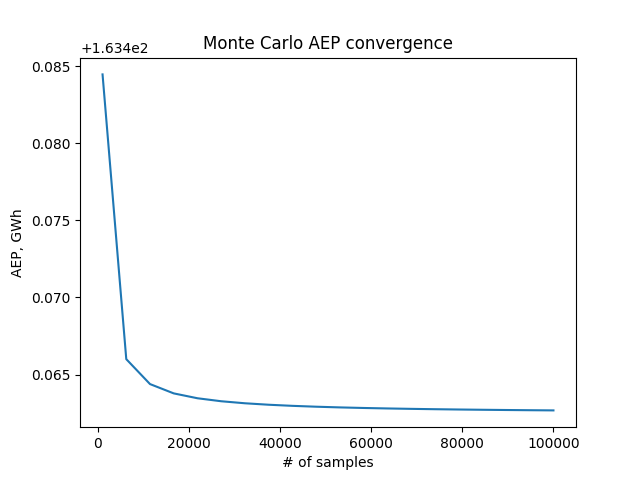

In [50]:
dist1 = cp.Uniform(0, 360)

dirs = dist1.sample(100000, "M")*np.pi/180.

# print dirs
solves1 = np.array([jensen_power(x_pos, y_pos, r_0, alpha, a, U_inf, rho, Cp, s) for s in dirs.T])/1e6

# print solves1

mu_mc = np.mean(solves)

AEP_mc = 8760*np.mean(mu_mc)/1e9

print "MC:", AEP_mc, " GWh"


MC: 155.069042548  GWh


### Results

|**Method**| **AEP (GWh) **|
|:---:|:---:|
| Deterministic (all points) | 157.759 |
|Deterministic (with quadrature points)| 157.874 |
|PC_regression| 157.750 |
|Monte Carlo| 155.194 |
